In [65]:
import numpy as np
import xarray as xr
import matplotlib as mpl 
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs      # Mapping  package https://scitools.org.uk/cartopy/docs/latest/
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean

## Xarray datasets

The xarray package is a powerful tool for working with climate data. It allows us to easily perform calculations and plot data. 

The most common file format in climate science is the 'netcdf' format. You can identify these by the suffix '.nc'. To get used to working with data stored in netcdf files, we are going to look at how to plot and analyse data of sea surface temperature (SST).

To begin, we will open the file 'OCEAN_TEMP_SALINITY_MONTHLY_V4R4.nc' using xarray. This highlights xarray's 'dataset' object. When we load a netcdf file, it is loaded as a 'dataset' that contains all of the data contained in the file. 

In [4]:
filepath = 'OCEAN_TEMP_SALINITY_MONTHLY_V4R4.nc'  # choose this dataset, monthly surface temperature data
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset> Size: 224MB
Dimensions:         (time: 216, bnds: 2, longitude: 720, latitude: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2000-01-16T12:00:00 ... 2017-12...
    time_bnds       (time, bnds) datetime64[ns] 3kB ...
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, bnds) float32 6kB ...
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, bnds) float32 3kB ...
    Z               float32 4B ...
    Z_bnds          (bnds) float32 8B ...
Dimensions without coordinates: bnds
Data variables:
    THETA           (time, latitude, longitude) float32 224MB ...
Attributes: (12/65)
    CDI:                             Climate Data Interface version 2.1.1 (ht...
    source:                          The ECCO V4r4 state estimate was produce...
    institution:                     NASA Jet Propulsion Laboratory (JPL)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    ...                              ...
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            7f98aa42-4159-11eb-84c4-0cc47a3f7bb1
    history_json:                    [{"$schema":"https:\/\/harmony.earthdata...
    CDO:                             Climate Data Operators version 2.1.1 (ht...

Above, we see a summary of the dataset. Datasets contain variables of interest. In our case, this dataset has SST data. A data variable is a function of various coordinated. This dataset contains 3 coordinates: time, latitude and longitude (ignore bnds).

The SST data is called "THETA" in this file. Click on the little page icon next to any of the data above to see the metadata. That includes more information about the variable.

Data can be accessed in the following way:

In [5]:
ds["time"]

<xarray.DataArray 'time' (time: 216)> Size: 2kB
array(['2000-01-16T12:00:00.000000000', '2000-02-15T12:00:00.000000000',
       '2000-03-16T12:00:00.000000000', ..., '2017-10-16T12:00:00.000000000',
       '2017-11-16T00:00:00.000000000', '2017-12-16T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-16T12:00:00 ... 2017-12-16T06:...
    Z        float32 4B ...
Attributes:
    standard_name:  time
    long_name:      center time of averaging period
    bounds:         time_bnds
    axis:           T

As we can see, this file contains monthly-averaged data from 2000 to 2017.

## Basic Averaging and Plotting

Let's look at the average SST over that period. Averages can be calculated using the '.mean' function:

In [7]:
SST_annual_mean = ds["THETA"].mean("time")
SST_annual_mean

<xarray.DataArray 'THETA' (latitude: 360, longitude: 720)> Size: 1MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.9105796, -1.9105796, -1.9105796, ..., -1.9105796, -1.9105796,
        -1.9105796],
       [-1.9130354, -1.9130354, -1.9130354, ..., -1.9130354, -1.9130354,
        -1.9130354],
       [-1.9157152, -1.9157152, -1.9157152, ..., -1.9157152, -1.9157152,
        -1.9157152]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    Z          float32 4B ...

As we can see, the data is no longer a function of time.

Let's plot this. Here is a helper function to plot data on the globe. Don't worry too much about the details of the code if you don't want to. Just make sure to look at what the arguments do.

In [130]:
def cylindrical_equidistant_projection(lats,lons,data,vmin,vmax,ctick_spacing,cmap='RdYlBu_r',c_label='',title='',fig=None,ax=None, glob=True):
    """
    A function to plot data on a globe
    """
    c_ticks = range(vmin,vmax+ctick_spacing,ctick_spacing)
    if fig is None:
        fig=plt.figure(figsize=(8, 5)) # initialize a figure
    
    lon2d, lat2d = np.meshgrid(lons, lats) # create 2D lat-lon grid
    if ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree()) # create axes with assigned Plate Carree map projection
        
    ax.set_title(title,y=1.1) # add a plot title
    if glob==True:
        ax.set_global() # show the entire globe
    ax.coastlines() # plot coastlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--') # add lon/lat grid lines
    gl.bottom_labels = False # do not label longitudes on bottom
    gl.right_labels  = False  # do not lobal latitudes on right
    gl.xformatter = LONGITUDE_FORMATTER # format in longitude format
    gl.yformatter = LATITUDE_FORMATTER  # format in latitude format
    cs=ax.pcolormesh(lons, lats, data,cmap=cmap,vmin=vmin,vmax=vmax) # plot data
    
    # create colorbar
    cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.975) # add colorbar axes at bottom
    cbar=fig.colorbar(cs,cax=cax,orientation='horizontal',ticks=c_ticks)        # add horizontal colorbar to this axes
    cbar.set_label(c_label)                                                     # label colorbar
    return ax

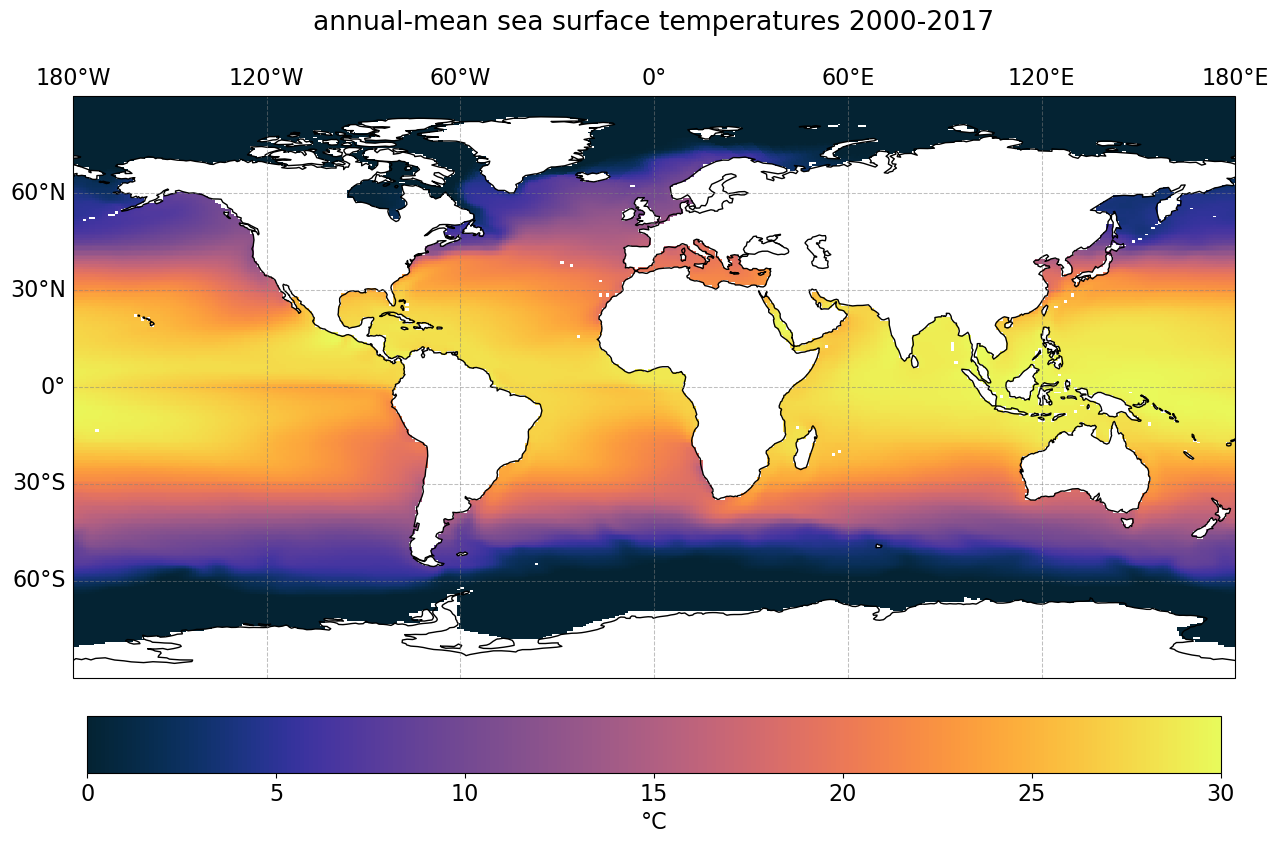

In [131]:
plt.rcParams.update({'font.size': 16})  # change the font size
fig = plt.figure(figsize=(15,10))       # initialize a fairly large figure
title = 'annual-mean sea surface temperatures 2000-2017'
ax = cylindrical_equidistant_projection(ds['latitude'],ds['longitude'],SST_annual_mean,
                                   0,30,5,
                                   cmap=cmocean.cm.thermal,c_label='°C',title=title,fig=fig)

Next, let's look at the seasonal cycle of SST. To do that we will average over latitude and longitude but not time.

However, we have to be careful because the Earth is a sphere. Each grid cell is 0.5$^\circ$x0.5$^\circ$. At higher latitudes, the area of a grid cell becomes smaller. If we were to do a naive average, it would overrepresent the polar regions. To correctly average, we need to weight the data appropriate. The correct weighting to account for the changing area is $\cos\phi$.

In [32]:
weight = np.cos(np.deg2rad(ds['latitude']))  
SST_weighted = ds['THETA'].weighted(weight) # calculate a weighted mean object in xarray ()

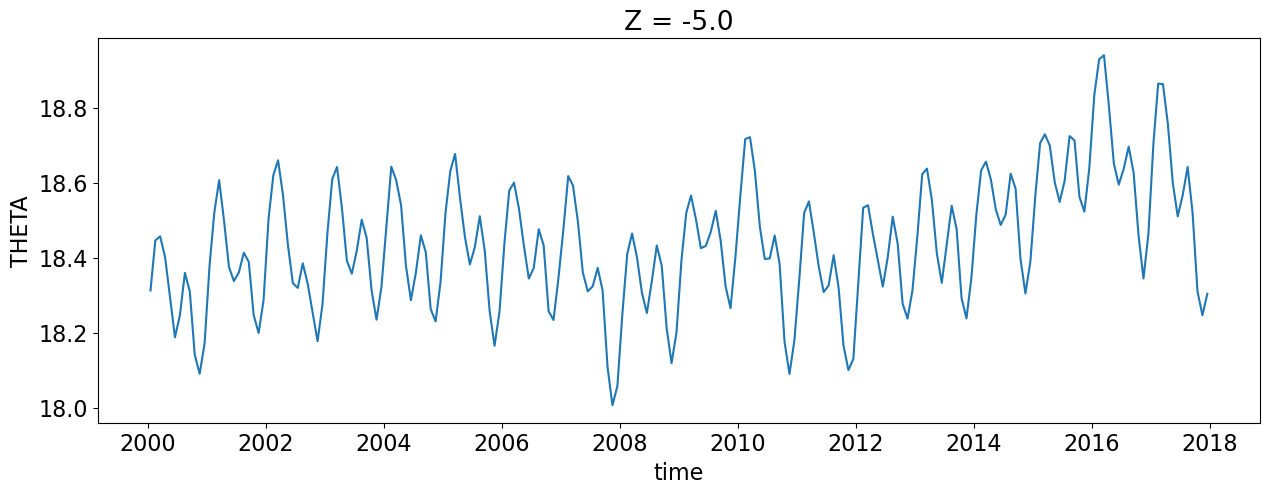

In [36]:
SST_global_mean = SST_weighted.mean(['latitude','longitude'])

fig = plt.figure(figsize=(15, 5)) # create a figure
ax  = plt.axes() 
SST_global_mean.plot(ax=ax)

## More complicated averaging

Suppose we are interested in the seasonal cycle. To calculate the mean seasonal cycle, we would average the global mean SST over every January in the record, followed by every February etc. We can do that using the 'groupby' function.

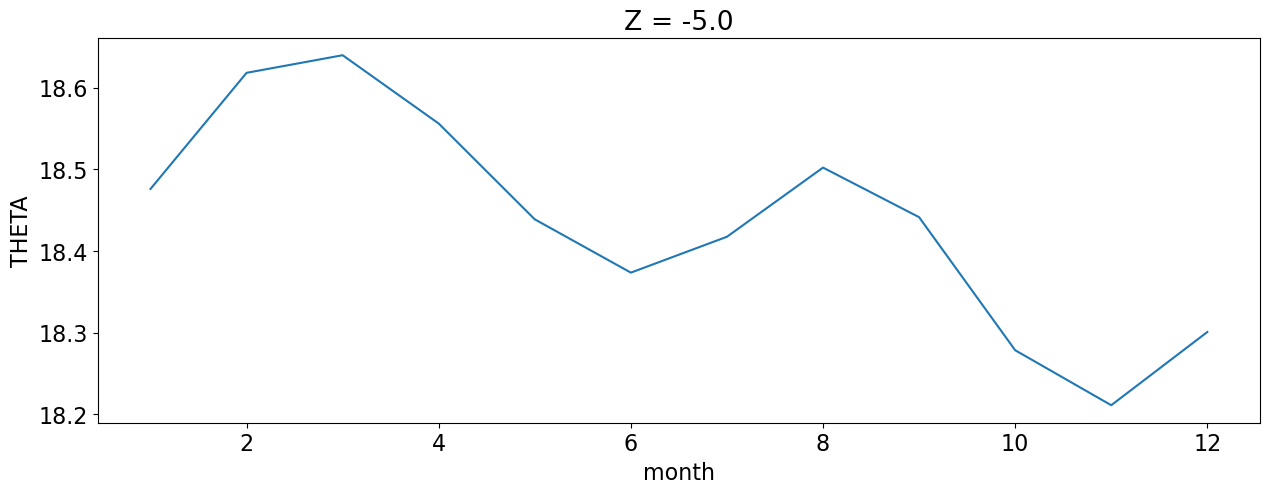

In [48]:
SST_seasonal_cycle = SST_global_mean.groupby('time.month').mean()
fig = plt.figure(figsize=(15, 5))
ax  = plt.axes() 
SST_seasonal_cycle.plot(ax=ax)

Next, suppose we are pnly interested in a certain region. We can subsample the dataset. Let's look at the US west-coast to begin with.

In [52]:
min_lon =  -150
min_lat = 30
max_lon = -110
max_lat = 60


ds_WC = ds.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))

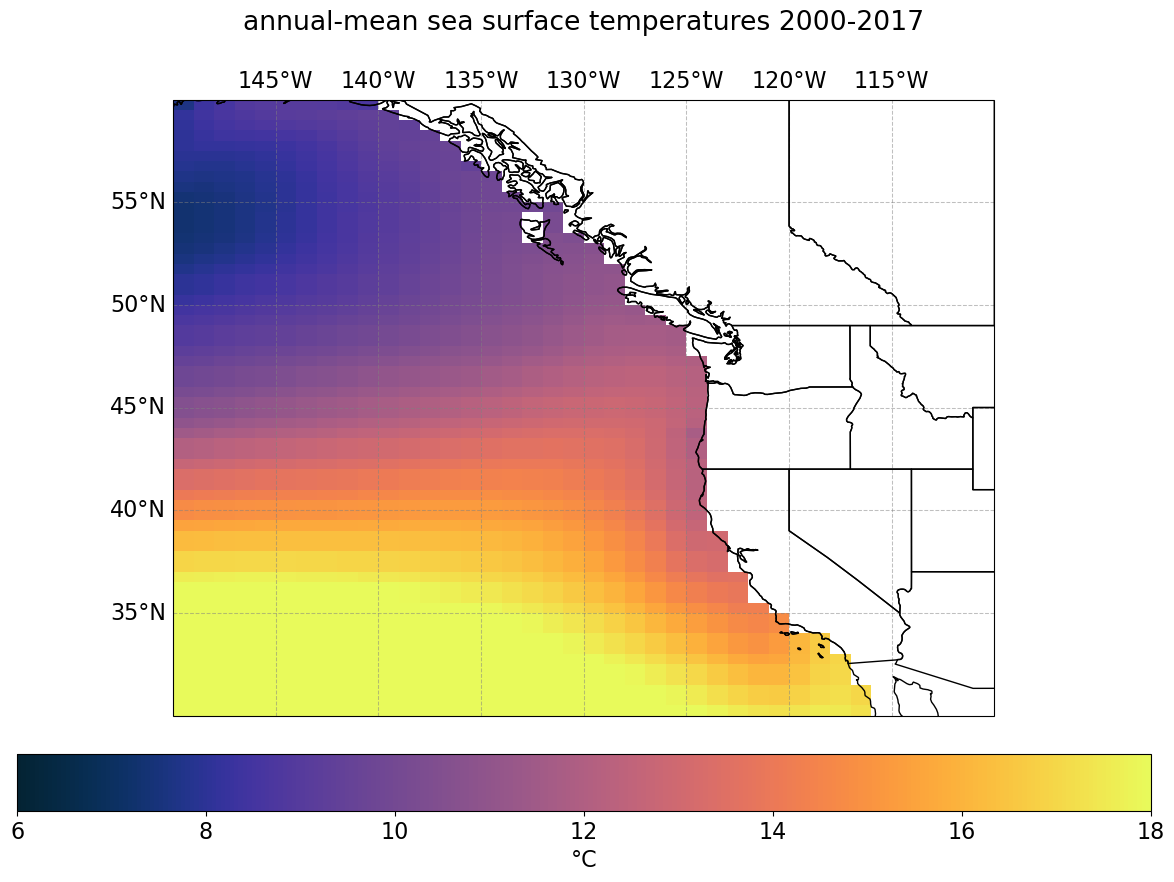

In [132]:
plt.rcParams.update({'font.size': 16})  # change the font size
fig = plt.figure(figsize=(15,10))       # initialize a fairly large figure
title = 'annual-mean sea surface temperatures 2000-2017'
ax = cylindrical_equidistant_projection(ds_WC['latitude'],ds_WC['longitude'],ds_WC["THETA"].mean("time"),
                                   6,18,2,
                                   cmap=cmocean.cm.thermal,c_label='°C',title=title,fig=fig,glob=False)
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)

## Try for yourself

1. We looked at a map of the annual mean SST. Let's make plots of the seasonal mean SST. To do this use 'groupby' with 'time.season'. Note that this uses meteorological seasons and are labelled using the months they contain e.g. "DJF" refers to December, January and February (or winter in the northern hemisphere). Fill in the '???' below:

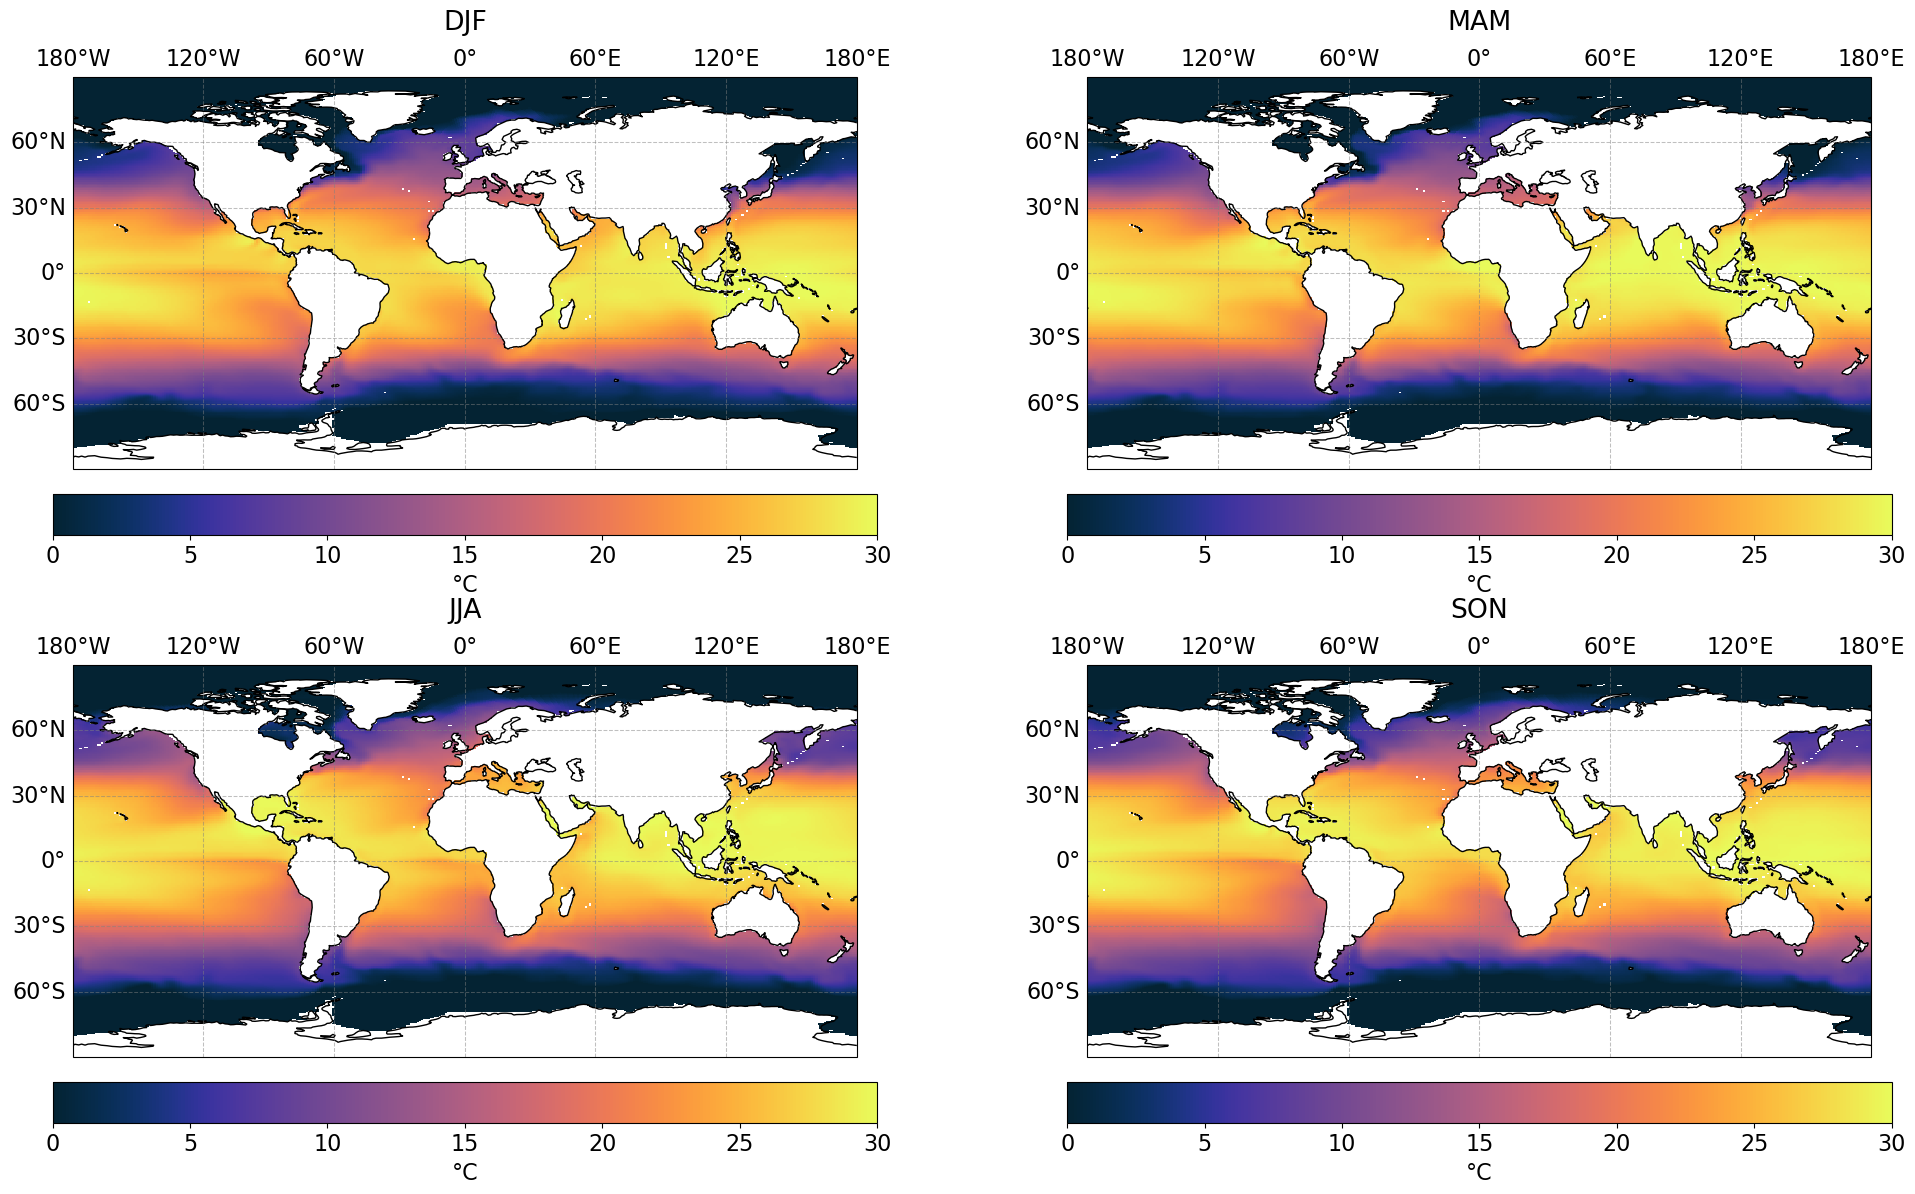

In [133]:
SST_seasonal_mean = ???

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    seas_data = SST_seasonal_mean.sel(season=season)
    ax = cylindrical_equidistant_projection(ds['latitude'],ds['longitude'],seas_data,
                                       0,30,5,cmap=cmocean.cm.thermal,
                                       c_label='°C',title=season,fig=fig,ax=axes.flatten()[i])

2. Our seasonal cycle above we relatively muted. We averaged over the entire globe which means northern hemisphere winter approximately cancels with southern hemisphere summer. Let's try looking at the seasonal cycle in just one hemisphere. Subset the dataset to just contain one hemisphere. Calculate the hemisphere mean temperature from 2000 to 2017 and the average seasonal cycle.

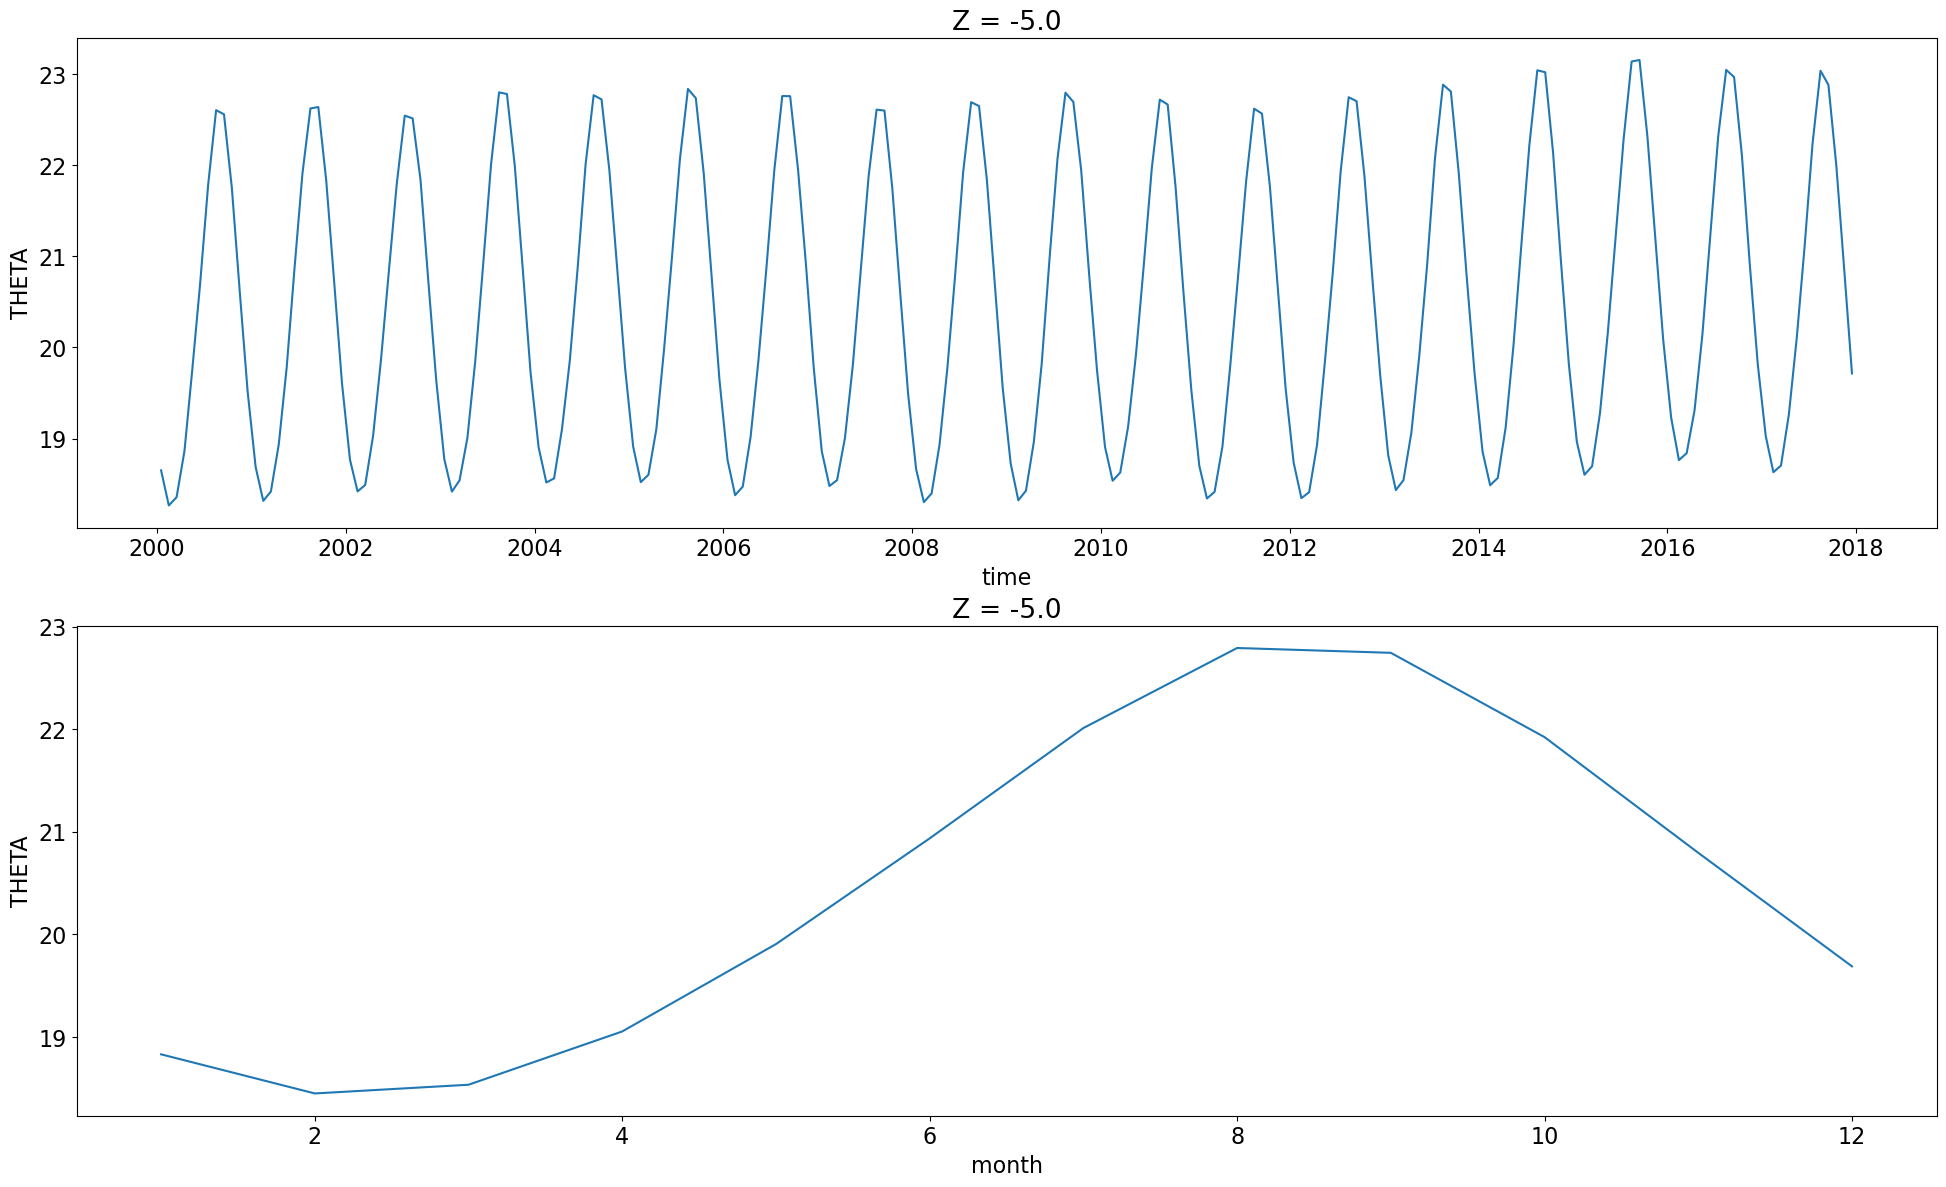

In [83]:
min_lat = 0
max_lat = 90


ds_NH = ???

weight = ???
SST_weighted_NH = ???
SST_NH_mean = ???
SST_NH_seasonal_cycle = ???

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24,14))
SST_NH_mean.plot(ax=axes[0])
SST_NH_seasonal_cycle.plot(ax=axes[1])

3. Let's try and calculate some anomalies. To do this, we subtract the temporal mean SST from the raw SST. Plot the SST anomaly for the warmest and coolest month in the period as measured by global mean SST. Use the 'argmax' and 'argmin' functions. We can also use 'isel' to select the appropriate months

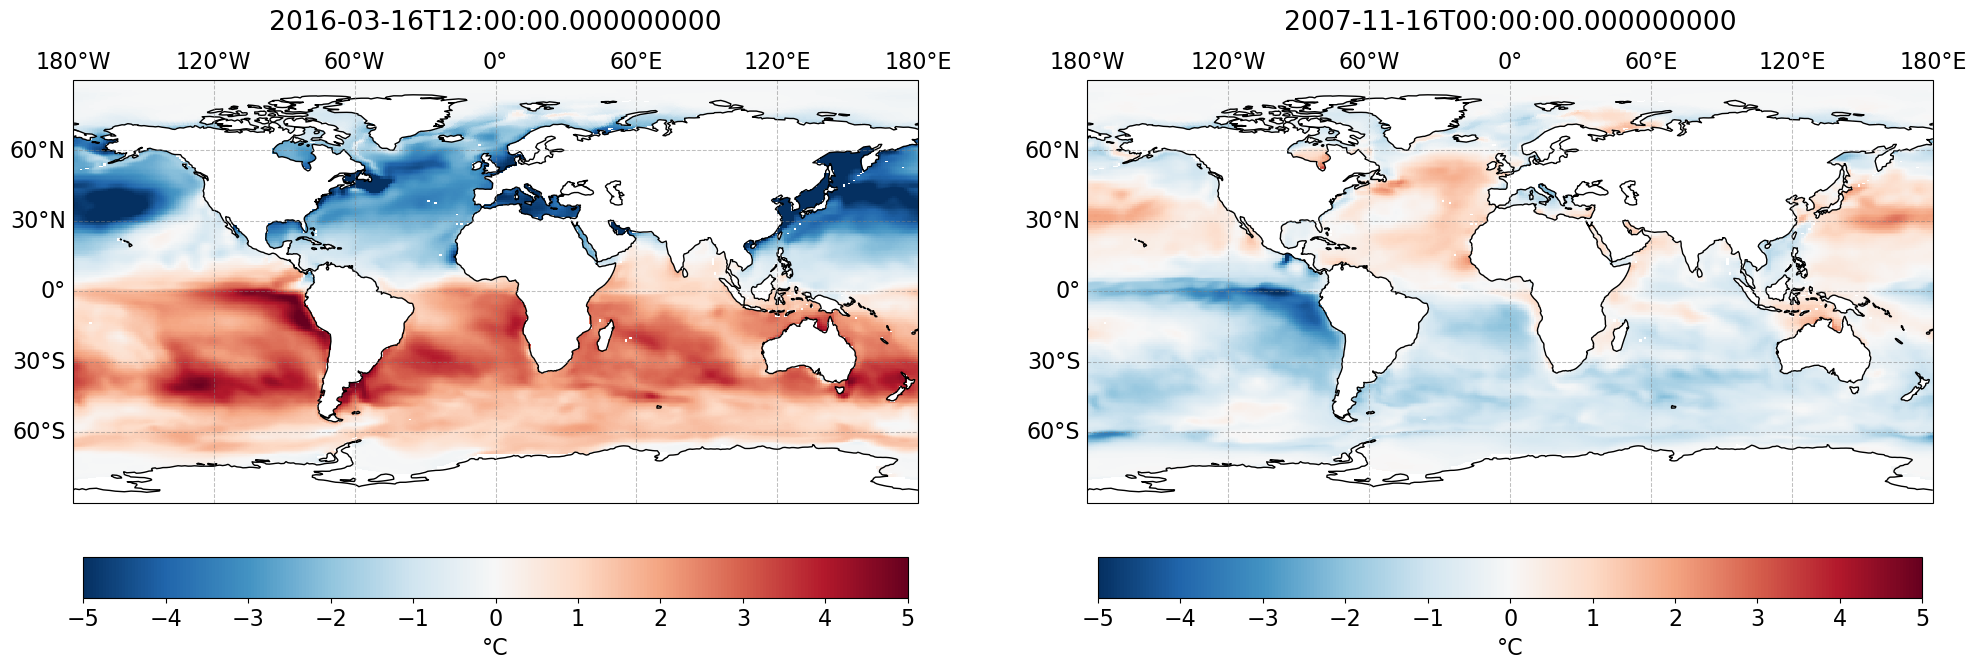

In [141]:
SST_anomaly = ???
weight = ???
SST_anomaly_weighted = ???
SST_anomaly_global_mean = ???

max_ind = SST_anomaly_global_mean.argmax().values
min_ind = SST_anomaly_global_mean.argmin().values

SST_warmest_month = SST_anomaly.isel(time=max_ind)
SST_coldest_month = SST_anomaly.isel(time=min_ind)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})

for i, month in enumerate((SST_warmest_month,SST_coldest_month)):

    ax = cylindrical_equidistant_projection(ds['latitude'],ds['longitude'],month,
                                       -5,5,1,cmap='RdBu_r',
                                       c_label='°C',title=month['time'].values,fig=fig,ax=axes.flatten()[i])

Hopefully you notice that these patterns just seem to represent a seasonal cycle with the hemispheres being either hotter or colder. For many purposes, it can be useful to look at anomalies that have this seasonal cycle removed. Repeat the above but remove a seasonal mean this time.

The difference is that above the anomaly tells us if the temperature is warmer or cooler that on average. If we remove a seaonal cycle, the anomaly tells us if the SST is warmer or cooler than on average for **that time of year**.

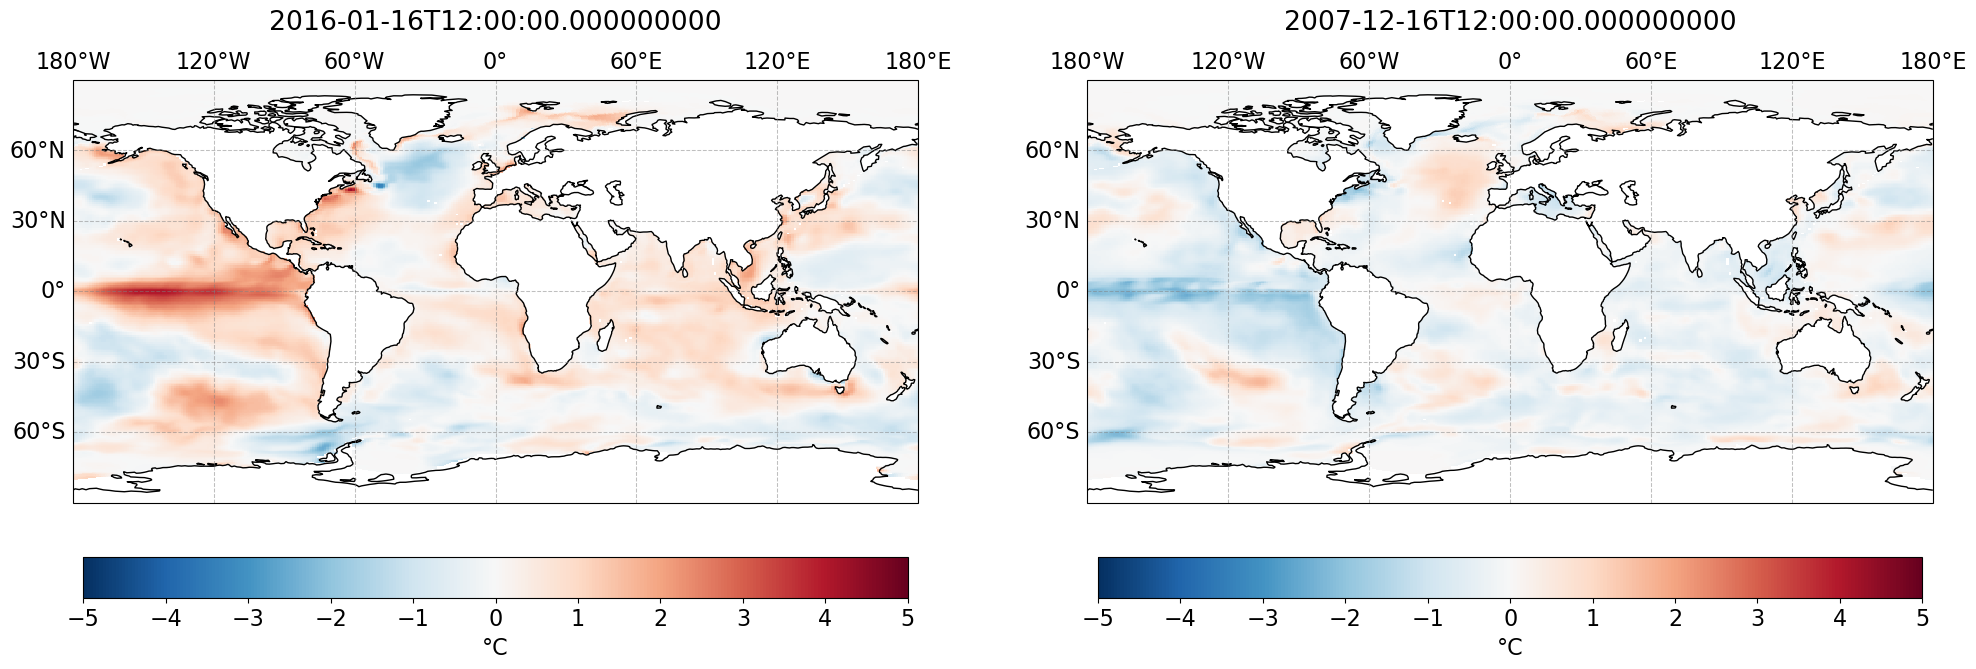

In [162]:
SST_anomaly = ???
weight = ???
SST_anomaly_weighted = ???
SST_anomaly_global_mean = ???

max_ind = SST_anomaly_global_mean.argmax().values
min_ind = SST_anomaly_global_mean.argmin().values

SST_warmest_month = SST_anomaly.isel(time=max_ind)
SST_coldest_month = SST_anomaly.isel(time=min_ind)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})

for i, month in enumerate((SST_warmest_month,SST_coldest_month)):

    ax = cylindrical_equidistant_projection(ds['latitude'],ds['longitude'],month,
                                       -5,5,1,cmap='RdBu_r',
                                       c_label='°C',title=month['time'].values,fig=fig,ax=axes.flatten()[i])

Can you see where the main contributions to this warming/cooling are?